## PCA и t-SNE, или зачем понижать размерность?

### Метод главных компонент, или PCA (Principal Components Analysis)

Рассмотрим работу с PCA на практике. Из датасетов sklearn импортируем датасет MNIST — это данные, основанные на рукописном начертании цифр:

![MNIST](img/MNIST.png)

Для данного датасета обучим модель, которая по пикселям изображения предсказывает, что за цифра на нём изображена. Первой мы разработаем модель, которая будет учитывать все признаки, а затем уменьшим размерность данных с помощью PCA и ещё раз обучим модель. Далее мы сравним качество полученных моделей и время, которое было затрачено на обучение в каждом случае.

В датасете MNIST представлено 70 000 изображений, каждое из которых описывается 784 признаками.

In [1]:
# загрузим датасет MNIST
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

dataset = fetch_openml("mnist_784")
# загрузим признаки в переменную X  
X = dataset['data']
# загрузим «ответы» в переменную y
y = dataset['target']
# разделим данные с помощью sklearn на данные для обучения и теста
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=0)

# импортируем StandardScaler для стандартизации данных
from sklearn.preprocessing import StandardScaler

# создадим объект класса StandardScaler
scaler = StandardScaler()
scaler.fit(train_x)
# трансформируем датасеты train_x и test_x
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

# импортируем класс PCA
from sklearn.decomposition import PCA

# создадим объект класса PCA
pca = PCA(n_components=300)
pca.fit(train_x)
# уменьшим размерность данных
train_x_pca = pca.transform(train_x)
test_x_pca = pca.transform(test_x)

c:\Users\jkons\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Посмотрим, сколько признаков описывало объект до и после уменьшения размерности. Как мы можем заметить, сначала было 787 признаков, а в конце объект описывают уже 300 главных компонент:

In [2]:
print(len(train_x[0]))
print(len(train_x_pca[0]))

784
300


Обучим модель логистической регрессии, которая на вход будет принимать пиксели изображения и предсказывать, что на нём нарисовано.

Напишем функцию, которая будет принимать на вход данные для обучения (матрицу с признаками и правильные ответы) и данные для тестирования модели, а на выходе будет возвращать время, затраченное на обучение модели, и качество модели. В качестве метрики оценивания качества будем использовать метрику accuracy.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from time import time

# напишем функцию, которая на вход принимает X и y, а возвращает модель и время
def get_time_and_accuracy(train_x, train_y, test_x, test_y):
    # создадим объект класса LogisticRegression
    log_reg_model = LogisticRegression(max_iter=1000)
    # запишем время с начала эпохи в секундах до обучения модели
    start_time = time()
    # обучим модель
    log_reg_model.fit(train_x, train_y)    
    # запишем время с начала эпохи в секундах после обучения
    end_time = time()
    # подсчитаем время, потраченное на обучение модели
    delta_time = end_time-start_time
    # предскажем на тестовых данных
    y_pred = log_reg_model.predict(test_x)
    # посчитаем скор для тестового предсказания
    score = accuracy_score(test_y, y_pred)
    # вернём время, потраченное на обучение, и качество полученной модели
    return delta_time, score

model_pca_time, model_pca_acc = get_time_and_accuracy(train_x_pca, train_y, test_x_pca, test_y)
print(f"Модель, построенная на признаках, полученных после уменьшения размерности. Время обучения {model_pca_time}, метрика модели {model_pca_acc}")
# Модель, построенная на признаках, полученных после уменьшения размерности. Время обучения 54.12072825431824, метрика модели 0.9255714285714286

model_time, model_acc = get_time_and_accuracy(train_x, train_y, test_x, test_y)
print(f"Модель, построенная на всех исходных признаках. Время обучения {model_time}, метрика модели {model_acc}")
# Модель, построенная на всех исходных признаках. Время обучения 108.04033303260803, метрика модели 0.9187142857142857

Модель, построенная на признаках, полученных после уменьшения размерности. Время обучения 180.43160581588745, метрика модели 0.9248571428571428
Модель, построенная на всех исходных признаках. Время обучения 431.2208580970764, метрика модели 0.9187142857142857


Как видим, в данном случае мы потратили на обучение модели в два раза меньше времени, а качество осталось практически таким же.

*В реальной работе бывает гораздо больше данных и на обучение модели уходит отнюдь не две минуты. Таким образом, применив технику уменьшения размерности, можно существенно сэкономить время.*

### Cтохастическое вложение соседей с t-распределением или T-SNE (t-distributed Stochastic Neighbor Embedding)

Уменьшим размерность с помощью PCA:

c:\Users\jkons\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


<AxesSubplot: xlabel='0', ylabel='1'>

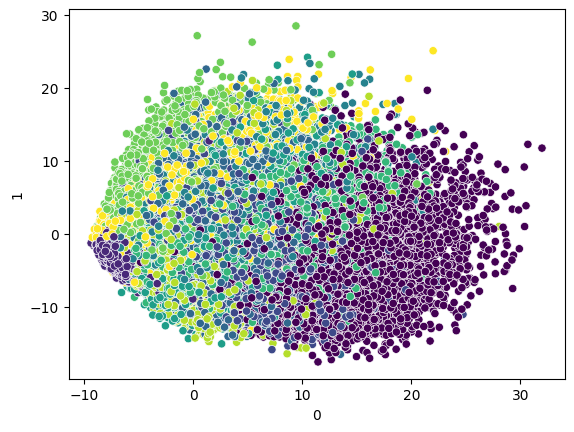

In [6]:
import pandas as pd
import seaborn as sns

df_pca = fetch_openml("mnist_784")
# создадим объект класса PCA, уменьшим размерность данных до 2
pca = PCA(n_components=2, random_state=42)
# уменьшим размерность данных
X_reduced = pca.fit_transform(train_x)
# сохраним данные в датафрейм
df_pca = pd.DataFrame(X_reduced)
# сохраним разметки кластеров
df_pca['c'] = pd.to_numeric(train_y).astype('Int64').to_list()
# визуализируем
sns.scatterplot(x=df_pca[0], y=df_pca[1], c=df_pca['c'])

Уменьшим размерность с помощью t-SNE:

c:\Users\jkons\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


<AxesSubplot: xlabel='0', ylabel='1'>

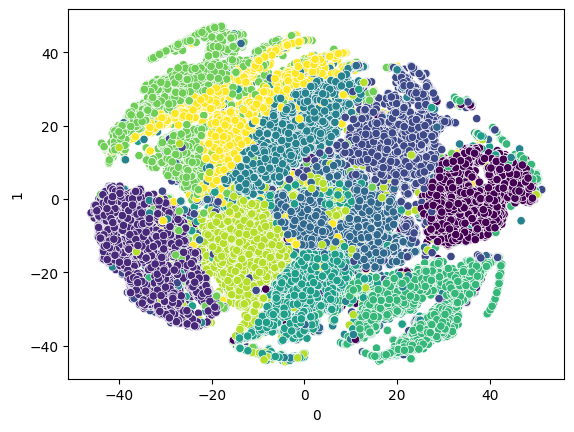

In [8]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

df_tsne = fetch_openml("mnist_784")
# создадим объект класса TSNE, уменьшим размерность данных до 2
tsne = TSNE(n_components=2, perplexity=50, n_iter=500, random_state=42)
# уменьшим размерность данных
X_reduced = tsne.fit_transform(train_x)
# сохраним данные в датафрейм
df_tsne = pd.DataFrame(X_reduced)
# сохраним разметки кластеров
df_tsne['c'] = pd.to_numeric(train_y).astype('Int64').to_list()# визуализируем
sns.scatterplot(x=df_tsne[0], y=df_tsne[1], c=df_tsne['c'])